In [1]:
# download and import the latest version of the chant module from IQ's github repository

import sys
# !rm -rf chant
# !git clone https://www.github.com/eyequeue/chant
# sys.path.append('github/chant')
import chant
import pandas as pd 
import numpy as np
pd.options.display.max_rows = 500



# put all the LMLO data in one dataframe (formerly known as "bigdata" or "bd")
lmlo = chant.cd.merge(chant.nd)



In [ ]:
!pip install cltk
import cltk
from cltk.stem.latin.syllabifier import Syllabifier
syllabifier = Syllabifier()


In [2]:
gamut_pitches = ['0f','0g','1a','1b','1c','1d','1e','1f','1g','2a','2b','2c','2d','2e','2f','2g','3a','3b','3c','3d','3e']
gamut_volpiano = ['8','9','a','b','c','d','e','f','g','h','j','k','l','m','n','o','p','q','r','s','t']
len(gamut_volpiano)

21

In [3]:
def v2r(v):
  if v == '':
    return v

  numbers = list()
  for vchar in v:
    numbers.append(gamut_volpiano.index(vchar))
  min_n = min(numbers)
  output = '<'
  for i in range(len(numbers)):
    output += f'{numbers[i] - min_n:x}' 
  output += '>'

  return output

from collections import defaultdict, Counter
lmlo_sylldata = defaultdict(list)
bad_words = Counter()
override = dict()
override['eius'] = ['e','ius']
override['dei'] = ['de','i']
override['deus'] = ['de','us']
override['quia'] = ['qui','a']
override['christi'] = ['chris','ti']
override['christe'] = ['chris','te']
override['eum'] = ['e','um']
override['deum'] = ['de','um']
override['meum'] = ['me','um']
override['meus'] = ['me','us']
override['christo'] = ['chris','to']
override['christus'] = ['chris','tus']
override['christum'] = ['chris','tum']
override['mei'] = ['me','i']
override['ei'] = ['e','i']
override['cui'] = ['cu','i']
override['israel'] = ['is','ra','el']
override['sanguine'] = ['san','gui','ne']
override['meis'] = ['me','is']
override['eis'] = ['e','is']
override['fidei'] = ['fi','de','i']
override['sanguinem'] = ['san','gui','nem']
override['lingua'] = ['lin','gua']
override['thronum'] = ['thro','num']
override['pulchra'] = ['pul','chra']
override['oleum'] = ['o','le','um']
override['adiutor'] = ['ad','iu','tor']
override['sanguis'] = ['san','guis']
override['sanguinis'] = ['san','gui','nis']
override['huic'] = ['hu','ic']
override['alleluia'] = ['al','le','lu','ia']
override['michael'] = ['mi','cha','el']
override['noe'] = ['no','e']

for i, c in chant.cd.iterrows():
  # if i>200: break
  words = c.text.lower().split()
  vwords = c.volpiano[4:-3].split('--')
  if len(words) != len(vwords):
    # print(f'oops: {len(words)} {len(vwords)}')
    # print(words)
    # print(vwords)    
    vwords[-2] = vwords[-2] + '-' + vwords[-1]
    vwords.pop(-1)
    # print('--fixing--')
    # print(words)
    # print(vwords)
  for j in range(len(words)):
    if words[j] in override:
      sylls = override[words[j]]
    else:
      sylls = syllabifier.syllabify(words[j].lower())
    vsylls = vwords[j].split('-')
    if len(sylls) != len(vsylls):
      sylls = [f'[{words[j]}]'] * len(vsylls)
    for k in range(len(vsylls)):
      lmlo_sylldata['chantID'].append(c.chantID)
      lmlo_sylldata['syllable'].append(sylls[k])
      lmlo_sylldata['last_syll'].append(k+1 == len(vsylls))
      v = vsylls[k]
      lmlo_sylldata['n_notes'].append(len(v))
      lmlo_sylldata['volpiano'].append(v)
      notes = ''
      for vchar in v:
        notes += f'{gamut_pitches[gamut_volpiano.index(vchar)]} '
      lmlo_sylldata['notes'].append(notes)
      lmlo_sylldata['finalpitch'].append(gamut_pitches[gamut_volpiano.index(v[-1])])
      lmlo_sylldata['t_type'].append(v2r(v))
      lmlo_sylldata['e_type'].append(v2r(v[0]+v[-1]))

lmlo_sylldata = pd.DataFrame(lmlo_sylldata)
lmlo_sylldata = lmlo_sylldata.join(lmlo.modus, on='chantID')



# Exploring `e_type`

Two-note syllables are more likely to be descending if stepwise, and more likely to ascend if leaping.

Three-, five-, and seven-note syllables are most likely to have an e_type of <02> or <20>. For the rest it's <01> or <10>. 

* This makes sense in the three-note case: fill in the third.

* Five notes: the vast majority are stepwise elaborations, which "naturally" have an odd number of notes. The main exception is t-type <01312>, which is probably on G-b and possibly on F-a or c-e, and which is modally unspecific. 

In [3]:
df = lmlo_sylldata
pd.crosstab(df.n_notes, df.e_type)

NameError: ignored

In [ ]:
df = lmlo_sylldata.query('n_notes == 7')
display(pd.crosstab(df.t_type, df.e_type).sort_values('<02>', ascending=False).head(10))
display(pd.crosstab(df.t_type, df.e_type).sort_values('<20>', ascending=False).head(10))


e_type,<00>,<01>,<02>,<03>,<04>,<05>,<06>,<07>,<10>,<20>,<30>,<40>,<50>,<60>
t_type,,,,,,,,,,,,,,
<0121232>,0,0,121,0,0,0,0,0,0,0,0,0,0,0
<0123212>,0,0,38,0,0,0,0,0,0,0,0,0,0,0
<1012123>,0,0,33,0,0,0,0,0,0,0,0,0,0,0
<2103234>,0,0,23,0,0,0,0,0,0,0,0,0,0,0
<1210123>,0,0,14,0,0,0,0,0,0,0,0,0,0,0
<1012323>,0,0,9,0,0,0,0,0,0,0,0,0,0,0
<0131232>,0,0,6,0,0,0,0,0,0,0,0,0,0,0
<0121012>,0,0,4,0,0,0,0,0,0,0,0,0,0,0
<0245432>,0,0,4,0,0,0,0,0,0,0,0,0,0,0


e_type,<00>,<01>,<02>,<03>,<04>,<05>,<06>,<07>,<10>,<20>,<30>,<40>,<50>,<60>
t_type,,,,,,,,,,,,,,
<3212101>,0,0,0,0,0,0,0,0,0,63,0,0,0,0
<2121010>,0,0,0,0,0,0,0,0,0,58,0,0,0,0
<2343210>,0,0,0,0,0,0,0,0,0,30,0,0,0,0
<2323210>,0,0,0,0,0,0,0,0,0,16,0,0,0,0
<2123210>,0,0,0,0,0,0,0,0,0,15,0,0,0,0
<3210121>,0,0,0,0,0,0,0,0,0,15,0,0,0,0
<2132120>,0,0,0,0,0,0,0,0,0,14,0,0,0,0
<2321010>,0,0,0,0,0,0,0,0,0,13,0,0,0,0
<4321012>,0,0,0,0,0,0,0,0,0,12,0,0,0,0


In [ ]:
df = lmlo_sylldata.query('e_type == "<01>"')
pd.crosstab(df.t_type, df.finalpitch, margins = True).query('All>20').sort_values('All')

finalpitch,1a,1b,1c,1d,1e,1f,1g,2a,2b,2c,2d,2e,2f,2g,3a,3b,3c,All
t_type,,,,,,,,,,,,,,,,,,
<01321>,0,0,0,4,0,0,0,12,0,0,7,0,0,0,0,0,0,23
<0131>,0,0,0,2,0,0,1,17,0,0,2,1,0,0,0,0,0,23
<0231>,0,0,0,18,0,0,1,4,0,0,2,0,0,0,0,0,0,25
<210123>,0,0,0,0,0,6,6,0,1,8,6,0,0,1,0,0,0,28
<21012123>,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,32
<0123121>,0,0,0,0,0,0,32,0,0,0,1,0,0,0,0,0,0,33
<2103>,0,0,0,0,0,5,11,0,0,11,4,0,1,2,0,0,0,34
<010121>,0,0,0,0,0,0,3,21,0,0,2,13,0,0,0,0,0,39
<02101>,0,0,0,0,6,3,5,10,15,1,0,1,0,0,0,0,0,41


In [ ]:
# tops = list(lmlo_sylldata.query('modus=="4e"').notes.value_counts()[:50].index)
# print(tops)
# df = lmlo_sylldata.query(f'notes in {tops}')

df = lmlo_sylldata.query('t_type == "<024>"')
pd.crosstab(df.notes, df.modus)

modus,1d,2d,3e,4e,5f,6c,7g,8g
notes,,,,,,,,
1c 1e 1g,2,0,0,1,0,0,1,0
1d 1f 2a,3,1,3,0,5,5,0,1
1f 2a 2c,58,9,19,12,29,15,14,4
1g 2b 2d,1,0,0,1,3,0,0,0
2c 2e 2g,9,1,0,1,11,1,11,1


In [ ]:
from scipy.stats import entropy
df = lmlo_sylldata.query('t_type == "<024>"')
np.e ** entropy(df.notes.value_counts())


2.4321733957991087

In [30]:
ct = pd.crosstab(lmlo.pitch_rel, lmlo.modus, normalize='index', margins=True)
sns.scatterplot(data=pd.DataFrame(ct.unstack()),y='pitch_rel',x='modus',size=0)

TypeError: ignored

In [29]:
pd.DataFrame(ct.unstack())

0
modus pitch_rel          
6c    2.3        0.000000
      2.2        0.008493
      2.1        0.008601
      1.7        0.007950
      1.6        0.025244
      1.5        0.041679
      1.4        0.046610
      1.3        0.071455
      1.2        0.086706
      1.1        0.088905
      0.7        0.051799
      0.6        0.219041
      0.5        0.188921
      0.4        0.055556
      All        0.067792
2d    2.3        0.000000
      2.2        0.000000
      2.1        0.001518
      1.7        0.003226
      1.6        0.008897
      1.5        0.034694
      1.4        0.064025
      1.3        0.107664
      1.2        0.102261
      1.1        0.139159
      0.7        0.177261
      0.6        0.038282
      0.5        0.209302
      0.4        0.078947
      All        0.093456
4e    2.3        0.000000
      2.2        0.000000
      2.1        0.001518
      1.7        0.010139
      1.6        0.038482
      1.5        0.022086
      1.4        0.089946
      1.3        0.117415
      1.2        0.119761
      1.1        0.095342
      0.7        0.181793
      0.6        0.207723
      0.5        0.002090
      0.4        0.014620
      All        0.093719
6f    2.3        0.000000
      2.2        0.023355
      2.1        0.024538
      1.7        0.019472
      1.6        0.029907
      1.5        0.037229
      1.4        0.031662
      1.3        0.067684
      1.2        0.087089
      1.1        0.081653
      0.7        0.034546
      0.6        0.163948
      0.5        0.139535
      0.4        0.005848
      All        0.061011
8g    2.3        0.000000
      2.2        0.002123
      2.1        0.008095
      1.7        0.013135
      1.6        0.029264
      1.5        0.066772
      1.4        0.139269
      1.3        0.085999
      1.2        0.202734
      1.1        0.203293
      0.7        0.235619
      0.6        0.305093
      0.5        0.422785
      0.4        0.842105
      All        0.147038
1d    2.3        0.724138
      2.2        0.346072
      2.1        0.365292
      1.7        0.377002
      1.6        0.194126
      1.5        0.348696
      1.4        0.295516
      1.3        0.257275
      1.2        0.171003
      1.1        0.207593
      0.7        0.201153
      0.6        0.003162
      0.5        0.019336
      0.4        0.000000
      All        0.240765
3e    2.3        0.000000
      2.2        0.014862
      2.1        0.069820
      1.7        0.148750
      1.6        0.249491
      1.5        0.081874
      1.4        0.114520
      1.3        0.113328
      1.2        0.058389
      1.1        0.049719
      0.7        0.065434
      0.6        0.025965
      0.5        0.000000
      0.4        0.000000
      All        0.088428
5f    2.3        0.206897
      2.2        0.416136
      2.1        0.298760
      1.7        0.177785
      1.6        0.195466
      1.5        0.152932
      1.4        0.062380
      1.3        0.098184
      1.2        0.068647
      1.1        0.051310
      0.7        0.006559
      0.6        0.022304
      0.5        0.010452
      0.4        0.000000
      All        0.086093
7g    2.3        0.068966
      2.2        0.188960
      2.1        0.221857
      1.7        0.242539
      1.6        0.229124
      1.5        0.214038
      1.4        0.156072
      1.3        0.080996
      1.2        0.103409
      1.1        0.083027
      0.7        0.045836
      0.6        0.014481
      0.5        0.007578
      0.4        0.002924
      All        0.121699

In [4]:
mode_order_vert = ['7g','5f','3e','1d','8g','6f','4e','2d','6c']
mode_order_horiz = ['6c','2d','4e','6f','8g','1d','3e','5f','7g']
pitch_rel_order_vert = ['2.5','2.4','2.3','2.2','2.1','1.7','1.6','1.5','1.4','1.3','1.2','1.1','0.7','0.6','0.5','0.4','0.3']
pitch_abs_order_vert = ['3.d','3.c','3.b','3.a','2.g','2.f','2.e','2.d','2.c','2.b','2.a','1.g','1.f','1.e','1.d','1.c','1.b','1.a','0.g']
from pandas.api.types import CategoricalDtype
mode_type = CategoricalDtype(categories=mode_order_horiz, ordered=True)
lmlo.modus = lmlo.modus.astype(mode_type)
pitch_rel_type = CategoricalDtype(categories=pitch_rel_order_vert, ordered=True)
lmlo.pitch_rel = lmlo.pitch_rel.astype(pitch_rel_type)
pitch_abs_type = CategoricalDtype(categories=pitch_abs_order_vert, ordered=True)
lmlo.pitch_abs = lmlo.pitch_abs.astype(pitch_abs_type)


pitch_order = ['0.g','1.a','1.b']
import seaborn as sns

def change_it(item):
    if item == 99:
        return 10
    else:
        return item
lmlo.lint = lmlo.lint.apply(change_it)
lmlo.rint = lmlo.rint.apply(change_it)
figdata = lmlo.query(f'modus in {mode_order_horiz}').groupby(['modus','pitch_abs']).count()


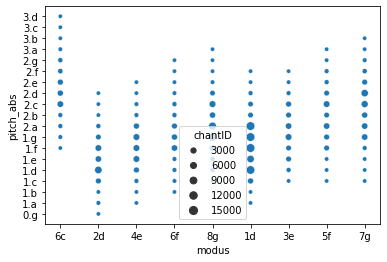

In [48]:
lmlo

,chantID,corpus,subcorpus,Modus,modus,maneria,ambitus,office,Service,service,ordinal,Genre,genre,text,volpiano,word,syll,note,boundary_before,boundary_after,reg_abs,pc_abs,pitch_abs,reg_rel,pc_rel,pitch_rel,lint,lint_class,lint_dir,rint,rint_class,rint_dir
0,0,L,LS,1d,1d,protus,authentic,ADALARDUS Adlrd,V,V,1,E,E,gloria sanctoruM rex unica christe tuoruM nos ...,1---df-ed-e--dc-ded-d--fe--fg-gf-gh--hgef-ed--...,0,0,0,2,0,1,d,1.d,1,1,1.1,10,edge,edge,2,slip,up
1,0,L,LS,1d,1d,protus,authentic,ADALARDUS Adlrd,V,V,1,E,E,gloria sanctoruM rex unica christe tuoruM nos ...,1---df-ed-e--dc-ded-d--fe--fg-gf-gh--hgef-ed--...,0,0,1,0,1,1,f,1.f,1,3,1.3,2,slip,up,-1,step,down
2,0,L,LS,1d,1d,protus,authentic,ADALARDUS Adlrd,V,V,1,E,E,gloria sanctoruM rex unica christe tuoruM nos ...,1---df-ed-e--dc-ded-d--fe--fg-gf-gh--hgef-ed--...,0,1,0,1,0,1,e,1.e,1,2,1.2,-1,step,down,-1,step,down
3,0,L,LS,1d,1d,protus,authentic,ADALARDUS Adlrd,V,V,1,E,E,gloria sanctoruM rex unica christe tuoruM nos ...,1---df-ed-e--dc-ded-d--fe--fg-gf-gh--hgef-ed--...,0,1,1,0,1,1,d,1.d,1,1,1.1,-1,step,down,1,step,up
4,0,L,LS,1d,1d,protus,authentic,ADALARDUS Adlrd,V,V,1,E,E,gloria sanctoruM rex unica christe tuoruM nos ...,1---df-ed-e--dc-ded-d--fe--fg-gf-gh--hgef-ed--...,0,2,0,1,2,1,e,1.e,1,2,1.2,1,step,up,-1,step,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423454,5949,L,H,6c,6c,tritus,plagal,"BVM, Lady office on Saturdays",C,H,2,$,O,ave regina celoruM ave domina angeloruM salve ...,1---kjhk-ghk--k-lm-m--lm-nml-k--kjhj-ghk--k-lm...,29,2,0,1,0,2,d,2.d,1,2,1.2,1,step,up,1,step,up
423455,5949,L,H,6c,6c,tritus,plagal,"BVM, Lady office on Saturdays",C,H,2,$,O,ave regina celoruM ave domina angeloruM salve ...,1---kjhk-ghk--k-lm-m--lm-nml-k--kjhj-ghk--k-lm...,29,2,1,0,0,2,e,2.e,1,3,1.3,1,step,up,-1,step,down
423456,5949,L,H,6c,6c,tritus,plagal,"BVM, Lady office on Saturdays",C,H,2,$,O,ave regina celoruM ave domina angeloruM salve ...,1---kjhk-ghk--k-lm-m--lm-nml-k--kjhj-ghk--k-lm...,29,2,2,0,0,2,d,2.d,1,2,1.2,-1,step,down,-1,step,down
423457,5949,L,H,6c,6c,tritus,plagal,"BVM, Lady office on Saturdays",C,H,2,$,O,ave regina celoruM ave domina angeloruM salve ...,1---kjhk-ghk--k-lm-m--lm-nml-k--kjhj-ghk--k-lm...,29,2,3,0,1,2,c,2.c,1,1,1.1,-1,step,down,0,rep,rep
